In [1]:
# import dependencies
import matplotlib
import matplotlib.pyplot as plt
from climata.usgs import DailyValueIO
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

register_matplotlib_converters()
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20.0, 10.0)


## Get current USGS data from climata library 

### 08146000 @ San Saba

In [6]:
# set parameters
nyears = 107
ndays = 365 * nyears
station_id = "08146000"
param_id = "00060"

datelist = pd.date_range(end=pd.datetime.today(), periods=ndays).tolist()
data = DailyValueIO(
    start_date=datelist[0],
    end_date=datelist[-1],
    station=station_id,
    parameter=param_id,
)

<ipython-input-6-f243ec6c1f0e>:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  datelist = pd.date_range(end=pd.datetime.today(), periods=ndays).tolist()


In [7]:
# create lists of date-flow values
for series in data:
    flow = [r[1] for r in series.data]
    dates = [r[0] for r in series.data]

In [8]:
fig1=plt.plot(dates, flow)
plt.xlabel('Date')
plt.ylabel('Streamflow (cfs)')
plt.title(series.site_name)
plt.xticks(rotation='vertical')
plt.savefig('SS_08146000.png', bbox_inches='tight')
plt.show()

### For csv

In [3]:
nyears = 107
ndays = 365 * nyears
station = "08146000"
datelist = pd.date_range(end=pd.datetime.today(), periods=ndays).tolist()

data = DailyValueIO(
    start_date=datelist[0],
    end_date=datelist[-1],
    station=station,
)

date = []
value = []

for series in data:
    for row in series.data:
        date.append(row[0])
        value.append(row[1])

<ipython-input-3-a055e385b9d1>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  datelist = pd.date_range(end=pd.datetime.today(), periods=ndays).tolist()


In [4]:
# create lists of date-flow values
for series in data:
    flow = [r[1] for r in series.data]
    dates = [r[0] for r in series.data]

In [5]:
# create lists of date-flow values
site_names = [[series.site_name] * len(series.data) for series in data]

# unroll the list of lists
flat_site_names = [item for sublist in site_names for item in sublist]

In [6]:
# bundle the data into a data frame
df = pd.DataFrame({'site': flat_site_names, 
                   'date': date, 
                   'value': value})

# remove missing values
df = df[df['value'] != -999999.0]

In [7]:
df.head()

site       date  value
0  San Saba Rv at San Saba, TX 2007-10-01  165.0
1  San Saba Rv at San Saba, TX 2007-10-02  161.0
2  San Saba Rv at San Saba, TX 2007-10-03  157.0
3  San Saba Rv at San Saba, TX 2007-10-04  157.0
4  San Saba Rv at San Saba, TX 2007-10-05  154.0

In [8]:
# cfs to cms
df['value'] = df['value'].map(lambda value: value * 0.028316847)

In [9]:
df.head()

site       date     value
0  San Saba Rv at San Saba, TX 2007-10-01  4.672280
1  San Saba Rv at San Saba, TX 2007-10-02  4.559012
2  San Saba Rv at San Saba, TX 2007-10-03  4.445745
3  San Saba Rv at San Saba, TX 2007-10-04  4.445745
4  San Saba Rv at San Saba, TX 2007-10-05  4.360794

In [10]:
df.to_csv('SS_08146000.csv')

In [11]:
SS_08146000_df = pd.read_csv('SS_08146000.csv')

In [12]:
# create percentile_rank based off of value 'bottom10%', bottom11%-25%, 'middle25%-50%', 'top25%'
SS_08146000_df['percentile_rank']=SS_08146000_df.value.rank(pct=True)

In [13]:
# assign percentile class ()
SS_08146000_df['percentile_class']=pd.qcut(SS_08146000_df.percentile_rank,[0, 0.1, .5, .75, 1], labels=['bottom10%','bottom11%-25%', 'middle25%-50%', 'top25%'])

In [14]:
SS_08146000_df

Unnamed: 0                         site        date     value  \
0               0  San Saba Rv at San Saba, TX  2007-10-01  4.672280   
1               1  San Saba Rv at San Saba, TX  2007-10-02  4.559012   
2               2  San Saba Rv at San Saba, TX  2007-10-03  4.445745   
3               3  San Saba Rv at San Saba, TX  2007-10-04  4.445745   
4               4  San Saba Rv at San Saba, TX  2007-10-05  4.360794   
...           ...                          ...         ...       ...   
55947       55947  San Saba Rv at San Saba, TX  2021-11-12  0.082402   
55948       55948  San Saba Rv at San Saba, TX  2021-11-13  0.081836   
55949       55949  San Saba Rv at San Saba, TX  2021-11-14  0.082119   
55950       55950  San Saba Rv at San Saba, TX  2021-11-15  0.082119   
55951       55951  San Saba Rv at San Saba, TX  2021-11-16  0.081836   

       percentile_rank percentile_class  
0             0.836905           top25%  
1             0.832097           top25%  
2             0.827066           top25%  
3             0.827066           top25%  
4             0.823134           top25%  
...                ...              ...  
55947         0.078612        bottom10%  
55948         0.075306        bottom10%  
55949         0.076896        bottom10%  
55950         0.076896        bottom10%  
55951         0.075306        bottom10%  

[55952 rows x 6 columns]

In [15]:
SS_08146000_df["percentile_class"].value_counts()

bottom11%-25%    22442
middle25%-50%    13953
top25%           13942
bottom10%         5615
Name: percentile_class, dtype: int64

In [16]:
# Add new column called 'flow_class' (high or low) using .apply function
# Define function to map values (high or low)
def set_value (row_number, assigned_value):
    return assigned_value[row_number]

In [17]:
# Create dictionary defining values 
SS_08146000_dictionary = {'top25%': 'High', 'middle25%-50%':'Low', 'bottom11%-25%': 'Low', 'bottom10%':'Low'}

In [18]:
# Add new column named 'flow_class'
SS_08146000_df['flow_class'] = SS_08146000_df['percentile_class'].apply(set_value, args =(SS_08146000_dictionary, ))

In [19]:
SS_08146000_df['percentile_class'].value_counts()

bottom11%-25%    22442
middle25%-50%    13953
top25%           13942
bottom10%         5615
Name: percentile_class, dtype: int64

### List of conditions
- high flow pulse: anything below 2 cms in high flow class
- small flood minimum peak flow: between 2-9 cms in high flow class
- large flood minimum peak flow: anything = or > 10 cms in high flow class
- extreme low flows: anything below 10% of daily flows for the period
- low flows: the rest of low flows

In [18]:
# create a list of our conditions

conditions = [
    (SS_08146000_df['value'] < 2) & (SS_08146000_df['percentile_rank'] >=.75)& (SS_08146000_df['flow_class'] == 'High'),
    (SS_08146000_df['value'] >= 2) & (SS_08146000_df['percentile_rank'] >=.75)& (SS_08146000_df['value'] < 10) & (SS_08146000_df['flow_class'] == 'High'),
    (SS_08146000_df['value'] >= 10) & (SS_08146000_df['flow_class'] == 'High'), 
    (SS_08146000_df['percentile_rank'] >= 0.00) & (SS_08146000_df['percentile_rank'] <.10) & (SS_08146000_df['flow_class']== 'Low'),
    (SS_08146000_df['percentile_rank'] >= 0.10) & (SS_08146000_df['percentile_rank'] <=.75) & (SS_08146000_df['flow_class']== 'Low')
    
    ]
# create a list of the values we want to assign for each condition
values = ['high_flow_pulse', 'small_flood_min_peak_flow', 'large_flood_min_flow', 'extreme_low_flow', 'low_flow']
 



In [19]:
SS_08146000_df['value'] <2 & (SS_08146000_df['flow_class'] == 'High')

date
2007-10-01    False
2007-10-02    False
2007-10-03    False
2007-10-04    False
2007-10-05    False
              ...  
2021-11-12    False
2021-11-13    False
2021-11-14    False
2021-11-15    False
2021-11-16    False
Length: 55952, dtype: bool

In [20]:
# create a new column and use np.select to assign values to it using our lists as arguments
# create a new column and use np.select to assign values to it using our lists as arguments
SS_08146000_df['flow_component'] = np.select(conditions, values)

In [21]:
SS_08146000_df['flow_component'].value_counts()

low_flow                     36395
small_flood_min_peak_flow    10869
extreme_low_flow              5615
large_flood_min_flow          3073
Name: flow_component, dtype: int64

In [44]:
#SS_08146000_df["flow_component"].replace({"0": "low_flow",}, inplace=True)

In [45]:
SS_08146000_df

Unnamed: 0                         site        date     value  \
0               0  San Saba Rv at San Saba, TX  2007-10-01  4.672280   
1               1  San Saba Rv at San Saba, TX  2007-10-02  4.559012   
2               2  San Saba Rv at San Saba, TX  2007-10-03  4.445745   
3               3  San Saba Rv at San Saba, TX  2007-10-04  4.445745   
4               4  San Saba Rv at San Saba, TX  2007-10-05  4.360794   
...           ...                          ...         ...       ...   
55947       55947  San Saba Rv at San Saba, TX  2021-11-12  0.082402   
55948       55948  San Saba Rv at San Saba, TX  2021-11-13  0.081836   
55949       55949  San Saba Rv at San Saba, TX  2021-11-14  0.082119   
55950       55950  San Saba Rv at San Saba, TX  2021-11-15  0.082119   
55951       55951  San Saba Rv at San Saba, TX  2021-11-16  0.081836   

       percentile_rank percentile_class flow_class             flow_component  
0             0.836905           top25%       High  small_flood_min_peak_flow  
1             0.832097           top25%       High  small_flood_min_peak_flow  
2             0.827066           top25%       High  small_flood_min_peak_flow  
3             0.827066           top25%       High  small_flood_min_peak_flow  
4             0.823134           top25%       High  small_flood_min_peak_flow  
...                ...              ...        ...                        ...  
55947         0.078612        bottom10%        Low           extreme_low_flow  
55948         0.075306        bottom10%        Low           extreme_low_flow  
55949         0.076896        bottom10%        Low           extreme_low_flow  
55950         0.076896        bottom10%        Low           extreme_low_flow  
55951         0.075306        bottom10%        Low           extreme_low_flow  

[55952 rows x 8 columns]

In [46]:
del SS_08146000_df['Unnamed: 0']

In [47]:
SS_08146000_df.to_csv('SS_08146000.csv', index=False)

In [48]:
SS_08146000_df=pd.read_csv('SS_08146000.csv')

In [49]:
SS_08146000_df

site        date     value  percentile_rank  \
0      San Saba Rv at San Saba, TX  2007-10-01  4.672280         0.836905   
1      San Saba Rv at San Saba, TX  2007-10-02  4.559012         0.832097   
2      San Saba Rv at San Saba, TX  2007-10-03  4.445745         0.827066   
3      San Saba Rv at San Saba, TX  2007-10-04  4.445745         0.827066   
4      San Saba Rv at San Saba, TX  2007-10-05  4.360794         0.823134   
...                            ...         ...       ...              ...   
55947  San Saba Rv at San Saba, TX  2021-11-12  0.082402         0.078612   
55948  San Saba Rv at San Saba, TX  2021-11-13  0.081836         0.075306   
55949  San Saba Rv at San Saba, TX  2021-11-14  0.082119         0.076896   
55950  San Saba Rv at San Saba, TX  2021-11-15  0.082119         0.076896   
55951  San Saba Rv at San Saba, TX  2021-11-16  0.081836         0.075306   

      percentile_class flow_class             flow_component  
0               top25%       High  small_flood_min_peak_flow  
1               top25%       High  small_flood_min_peak_flow  
2               top25%       High  small_flood_min_peak_flow  
3               top25%       High  small_flood_min_peak_flow  
4               top25%       High  small_flood_min_peak_flow  
...                ...        ...                        ...  
55947        bottom10%        Low           extreme_low_flow  
55948        bottom10%        Low           extreme_low_flow  
55949        bottom10%        Low           extreme_low_flow  
55950        bottom10%        Low           extreme_low_flow  
55951        bottom10%        Low           extreme_low_flow  

[55952 rows x 7 columns]

In [50]:
# Add new column called 'flow_class' (high or low) using .apply function
# Define function to map values (high or low)
def set_value (row_number, assigned_value):
    return assigned_value[row_number]

In [51]:
# Create dictionary defining values 
SS_08146000_dictionary = {'top25%': 'High', 'middle25%-50%':'Low', 'bottom11%-25%': 'Low', 'bottom10%':'Low'}

In [52]:
# Add new column named 'flow_class'
SS_08146000_df['flow_class'] = SS_08146000_df['percentile_class'].apply(set_value, args =(SS_08146000_dictionary, ))

In [53]:
SS_08146000_df

site        date     value  percentile_rank  \
0      San Saba Rv at San Saba, TX  2007-10-01  4.672280         0.836905   
1      San Saba Rv at San Saba, TX  2007-10-02  4.559012         0.832097   
2      San Saba Rv at San Saba, TX  2007-10-03  4.445745         0.827066   
3      San Saba Rv at San Saba, TX  2007-10-04  4.445745         0.827066   
4      San Saba Rv at San Saba, TX  2007-10-05  4.360794         0.823134   
...                            ...         ...       ...              ...   
55947  San Saba Rv at San Saba, TX  2021-11-12  0.082402         0.078612   
55948  San Saba Rv at San Saba, TX  2021-11-13  0.081836         0.075306   
55949  San Saba Rv at San Saba, TX  2021-11-14  0.082119         0.076896   
55950  San Saba Rv at San Saba, TX  2021-11-15  0.082119         0.076896   
55951  San Saba Rv at San Saba, TX  2021-11-16  0.081836         0.075306   

      percentile_class flow_class             flow_component  
0               top25%       High  small_flood_min_peak_flow  
1               top25%       High  small_flood_min_peak_flow  
2               top25%       High  small_flood_min_peak_flow  
3               top25%       High  small_flood_min_peak_flow  
4               top25%       High  small_flood_min_peak_flow  
...                ...        ...                        ...  
55947        bottom10%        Low           extreme_low_flow  
55948        bottom10%        Low           extreme_low_flow  
55949        bottom10%        Low           extreme_low_flow  
55950        bottom10%        Low           extreme_low_flow  
55951        bottom10%        Low           extreme_low_flow  

[55952 rows x 7 columns]

In [33]:
#df2.pivot(index='index',columns = 'variable', values = 'value'))
# df.pivot(columns ='date', values = "value")

In [55]:
SS_08146000_df['date'] =  pd.to_datetime(SS_08146000_df['date'])

In [56]:
SS_08146000_df.dtypes

site                        object
date                datetime64[ns]
value                      float64
percentile_rank            float64
percentile_class            object
flow_class                  object
flow_component              object
dtype: object

In [164]:
#tidy = san_saba.groupby(['date', 'flow_components'])['value'].max().unstack().reset_index()

In [64]:
# serialize your DataFrame data
#SS_08146000_df.to_pickle('SS_08146000.zip')



In [2]:
# when needed, retrieve your data into a new DataFrame.
SS_08146000_df = pd.read_pickle('SS_08146000.zip')
SS_08146000_df.head()

site       date     value  percentile_rank  \
0  San Saba Rv at San Saba, TX 2007-10-01  4.672280         0.836905   
1  San Saba Rv at San Saba, TX 2007-10-02  4.559012         0.832097   
2  San Saba Rv at San Saba, TX 2007-10-03  4.445745         0.827066   
3  San Saba Rv at San Saba, TX 2007-10-04  4.445745         0.827066   
4  San Saba Rv at San Saba, TX 2007-10-05  4.360794         0.823134   

  percentile_class flow_class             flow_component  
0           top25%       High  small_flood_min_peak_flow  
1           top25%       High  small_flood_min_peak_flow  
2           top25%       High  small_flood_min_peak_flow  
3           top25%       High  small_flood_min_peak_flow  
4           top25%       High  small_flood_min_peak_flow

In [3]:
df= SS_08146000_df.groupby(SS_08146000_df["date"])
df.head()

site       date     value  percentile_rank  \
0      San Saba Rv at San Saba, TX 2007-10-01  4.672280         0.836905   
1      San Saba Rv at San Saba, TX 2007-10-02  4.559012         0.832097   
2      San Saba Rv at San Saba, TX 2007-10-03  4.445745         0.827066   
3      San Saba Rv at San Saba, TX 2007-10-04  4.445745         0.827066   
4      San Saba Rv at San Saba, TX 2007-10-05  4.360794         0.823134   
...                            ...        ...       ...              ...   
55947  San Saba Rv at San Saba, TX 2021-11-12  0.082402         0.078612   
55948  San Saba Rv at San Saba, TX 2021-11-13  0.081836         0.075306   
55949  San Saba Rv at San Saba, TX 2021-11-14  0.082119         0.076896   
55950  San Saba Rv at San Saba, TX 2021-11-15  0.082119         0.076896   
55951  San Saba Rv at San Saba, TX 2021-11-16  0.081836         0.075306   

      percentile_class flow_class             flow_component  
0               top25%       High  small_flood_min_peak_flow  
1               top25%       High  small_flood_min_peak_flow  
2               top25%       High  small_flood_min_peak_flow  
3               top25%       High  small_flood_min_peak_flow  
4               top25%       High  small_flood_min_peak_flow  
...                ...        ...                        ...  
55947        bottom10%        Low           extreme_low_flow  
55948        bottom10%        Low           extreme_low_flow  
55949        bottom10%        Low           extreme_low_flow  
55950        bottom10%        Low           extreme_low_flow  
55951        bottom10%        Low           extreme_low_flow  

[55952 rows x 7 columns]

## Multicolor lineplot for time series 

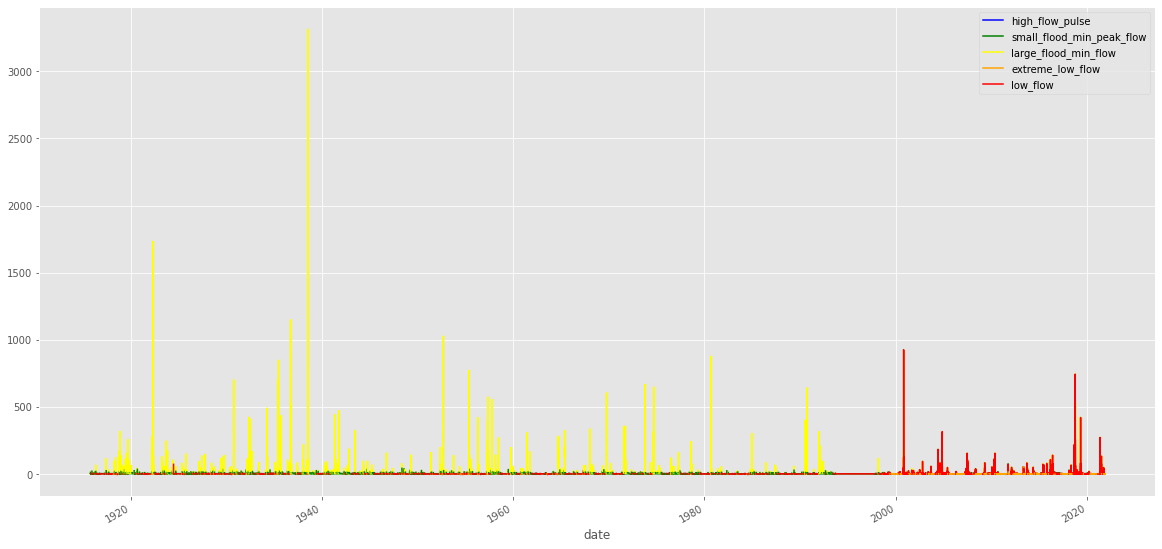

In [15]:
# data
df = SS_08146000_df
# Create plot
fig, ax = plt.subplots()

def gen_repeating(s):
    """Generator: groups repeated elements in an iterable
    E.g.
        'abbccc' -> [('a', 0, 0), ('b', 1, 2), ('c', 3, 5)]
    """
    i = 0
    while i < len(s):
        j = i
        while j < len(s) and s[j] == s[i]:
            j += 1
        yield (s[i], i, j-1)
        i = j

## Add flow value lines
for color, start, end in gen_repeating(df['color']):
    if start > 0: # make sure lines connect
        start -= 1
    idx = df.index[start:end+1]
    df.loc[idx, 'value'].plot(ax=ax, color=color, label='')

## Get artists and labels for legend and chose which ones to display
handles, flow_component = ax.get_legend_handles_labels()

## Create custom artists
b_line =plt.Line2D((0,1),(0,0), color='blue')
g_line = plt.Line2D((0,1),(0,0), color='green')
y_line = plt.Line2D((0,1),(0,0), color='yellow')
o_line = plt.Line2D((0,1),(0,0), color='orange')
r_line = plt.Line2D((0,1),(0,0), color='red')

## Create legend from custom artist/label lists
ax.legend(
    handles + [b_line,g_line, y_line, o_line, r_line],
    flow_component + [
        'high_flow_pulse',
        'small_flood_min_peak_flow',
        'large_flood_min_flow',
        'extreme_low_flow',
        'low_flow'
    ],
    loc='best',
)

# Display plot
plt.show()

In [4]:
df

In [5]:
SS_08146000_df.head()

site       date     value  percentile_rank  \
0  San Saba Rv at San Saba, TX 2007-10-01  4.672280         0.836905   
1  San Saba Rv at San Saba, TX 2007-10-02  4.559012         0.832097   
2  San Saba Rv at San Saba, TX 2007-10-03  4.445745         0.827066   
3  San Saba Rv at San Saba, TX 2007-10-04  4.445745         0.827066   
4  San Saba Rv at San Saba, TX 2007-10-05  4.360794         0.823134   

  percentile_class flow_class             flow_component  
0           top25%       High  small_flood_min_peak_flow  
1           top25%       High  small_flood_min_peak_flow  
2           top25%       High  small_flood_min_peak_flow  
3           top25%       High  small_flood_min_peak_flow  
4           top25%       High  small_flood_min_peak_flow

In [6]:
# create a list of our conditions
#'high_flow_pulse', 'small_flood_min_peak_flow', 'large_flood_min_flow', 'extreme_low_flow', 'low_flow'
conditions = [
    (SS_08146000_df['flow_component'] == 'high_flow_pulse' ),
    (SS_08146000_df['flow_component'] == 'small_flood_min_peak_flow' ),
    (SS_08146000_df['flow_component'] == 'large_flood_min_flow' ),
    (SS_08146000_df['flow_component'] == 'extreme_low_flow' ),
    (SS_08146000_df['flow_component'] == 'low_flow' ),    
    ]
# create a list of the values we want to assign for each condition
values = ['blue', 'green', 'yellow', 'orange', 'red']



In [7]:
# create a new column and use np.select to assign values to it using our lists as arguments
# create a new column and use np.select to assign values to it using our lists as arguments
SS_08146000_df['color'] = np.select(conditions, values)

In [8]:
SS_08146000_df

site       date     value  percentile_rank  \
0      San Saba Rv at San Saba, TX 2007-10-01  4.672280         0.836905   
1      San Saba Rv at San Saba, TX 2007-10-02  4.559012         0.832097   
2      San Saba Rv at San Saba, TX 2007-10-03  4.445745         0.827066   
3      San Saba Rv at San Saba, TX 2007-10-04  4.445745         0.827066   
4      San Saba Rv at San Saba, TX 2007-10-05  4.360794         0.823134   
...                            ...        ...       ...              ...   
55947  San Saba Rv at San Saba, TX 2021-11-12  0.082402         0.078612   
55948  San Saba Rv at San Saba, TX 2021-11-13  0.081836         0.075306   
55949  San Saba Rv at San Saba, TX 2021-11-14  0.082119         0.076896   
55950  San Saba Rv at San Saba, TX 2021-11-15  0.082119         0.076896   
55951  San Saba Rv at San Saba, TX 2021-11-16  0.081836         0.075306   

      percentile_class flow_class             flow_component   color  
0               top25%       High  small_flood_min_peak_flow   green  
1               top25%       High  small_flood_min_peak_flow   green  
2               top25%       High  small_flood_min_peak_flow   green  
3               top25%       High  small_flood_min_peak_flow   green  
4               top25%       High  small_flood_min_peak_flow   green  
...                ...        ...                        ...     ...  
55947        bottom10%        Low           extreme_low_flow  orange  
55948        bottom10%        Low           extreme_low_flow  orange  
55949        bottom10%        Low           extreme_low_flow  orange  
55950        bottom10%        Low           extreme_low_flow  orange  
55951        bottom10%        Low           extreme_low_flow  orange  

[55952 rows x 8 columns]

In [9]:
#SS_08146000_df.set_index('date', inplace=True)
SS_08146000_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55952 entries, 0 to 55951
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   site              55952 non-null  object        
 1   date              55952 non-null  datetime64[ns]
 2   value             55952 non-null  float64       
 3   percentile_rank   55952 non-null  float64       
 4   percentile_class  55952 non-null  object        
 5   flow_class        55952 non-null  object        
 6   flow_component    55952 non-null  object        
 7   color             55952 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 3.4+ MB


In [73]:
SS_08146000_df.head()

site     value  percentile_rank  \
date                                                                 
2007-10-01  San Saba Rv at San Saba, TX  4.672280         0.836905   
2007-10-02  San Saba Rv at San Saba, TX  4.559012         0.832097   
2007-10-03  San Saba Rv at San Saba, TX  4.445745         0.827066   
2007-10-04  San Saba Rv at San Saba, TX  4.445745         0.827066   
2007-10-05  San Saba Rv at San Saba, TX  4.360794         0.823134   

           percentile_class flow_class             flow_component  
date                                                               
2007-10-01           top25%       High  small_flood_min_peak_flow  
2007-10-02           top25%       High  small_flood_min_peak_flow  
2007-10-03           top25%       High  small_flood_min_peak_flow  
2007-10-04           top25%       High  small_flood_min_peak_flow  
2007-10-05           top25%       High  small_flood_min_peak_flow

In [10]:
df= SS_08146000_df.groupby(SS_08146000_df["date"])
df.head()

site       date     value  percentile_rank  \
0      San Saba Rv at San Saba, TX 2007-10-01  4.672280         0.836905   
1      San Saba Rv at San Saba, TX 2007-10-02  4.559012         0.832097   
2      San Saba Rv at San Saba, TX 2007-10-03  4.445745         0.827066   
3      San Saba Rv at San Saba, TX 2007-10-04  4.445745         0.827066   
4      San Saba Rv at San Saba, TX 2007-10-05  4.360794         0.823134   
...                            ...        ...       ...              ...   
55947  San Saba Rv at San Saba, TX 2021-11-12  0.082402         0.078612   
55948  San Saba Rv at San Saba, TX 2021-11-13  0.081836         0.075306   
55949  San Saba Rv at San Saba, TX 2021-11-14  0.082119         0.076896   
55950  San Saba Rv at San Saba, TX 2021-11-15  0.082119         0.076896   
55951  San Saba Rv at San Saba, TX 2021-11-16  0.081836         0.075306   

      percentile_class flow_class             flow_component   color  
0               top25%       High  small_flood_min_peak_flow   green  
1               top25%       High  small_flood_min_peak_flow   green  
2               top25%       High  small_flood_min_peak_flow   green  
3               top25%       High  small_flood_min_peak_flow   green  
4               top25%       High  small_flood_min_peak_flow   green  
...                ...        ...                        ...     ...  
55947        bottom10%        Low           extreme_low_flow  orange  
55948        bottom10%        Low           extreme_low_flow  orange  
55949        bottom10%        Low           extreme_low_flow  orange  
55950        bottom10%        Low           extreme_low_flow  orange  
55951        bottom10%        Low           extreme_low_flow  orange  

[55952 rows x 8 columns]

In [12]:
df.set_index('date', inplace=True)

In [13]:
df

site     value  percentile_rank  \
date                                                                 
2007-10-01  San Saba Rv at San Saba, TX  4.672280         0.836905   
2007-10-02  San Saba Rv at San Saba, TX  4.559012         0.832097   
2007-10-03  San Saba Rv at San Saba, TX  4.445745         0.827066   
2007-10-04  San Saba Rv at San Saba, TX  4.445745         0.827066   
2007-10-05  San Saba Rv at San Saba, TX  4.360794         0.823134   
...                                 ...       ...              ...   
2021-11-12  San Saba Rv at San Saba, TX  0.082402         0.078612   
2021-11-13  San Saba Rv at San Saba, TX  0.081836         0.075306   
2021-11-14  San Saba Rv at San Saba, TX  0.082119         0.076896   
2021-11-15  San Saba Rv at San Saba, TX  0.082119         0.076896   
2021-11-16  San Saba Rv at San Saba, TX  0.081836         0.075306   

           percentile_class flow_class             flow_component   color  
date                                                                       
2007-10-01           top25%       High  small_flood_min_peak_flow   green  
2007-10-02           top25%       High  small_flood_min_peak_flow   green  
2007-10-03           top25%       High  small_flood_min_peak_flow   green  
2007-10-04           top25%       High  small_flood_min_peak_flow   green  
2007-10-05           top25%       High  small_flood_min_peak_flow   green  
...                     ...        ...                        ...     ...  
2021-11-12        bottom10%        Low           extreme_low_flow  orange  
2021-11-13        bottom10%        Low           extreme_low_flow  orange  
2021-11-14        bottom10%        Low           extreme_low_flow  orange  
2021-11-15        bottom10%        Low           extreme_low_flow  orange  
2021-11-16        bottom10%        Low           extreme_low_flow  orange  

[55952 rows x 7 columns]

In [16]:
df.to_pickle('SS_08146000.zip')

### 08144500 @ Menard, TX

In [94]:
# set parameters
nyears = 107
ndays = 365 * nyears
station_id = "08144500"
param_id = "00060"

datelist = pd.date_range(end=pd.datetime.today(), periods=ndays).tolist()
data = DailyValueIO(
    start_date=datelist[0],
    end_date=datelist[-1],
    station=station_id,
    parameter=param_id,
)

<ipython-input-94-568c351fa2f8>:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  datelist = pd.date_range(end=pd.datetime.today(), periods=ndays).tolist()


In [53]:
# create lists of date-flow values
for series in data:
    flow = [r[1] for r in series.data]
    dates = [r[0] for r in series.data]

In [54]:
plt.plot(dates, flow)
plt.xlabel('Date')
plt.ylabel('Streamflow')
plt.title(series.site_name)
plt.xticks(rotation='vertical')
plt.savefig('SS_08144500.png', bbox_inches='tight')
plt.show()

### For csv

In [2]:
nyears = 107
ndays = 365 * nyears
station = "08144500"
datelist = pd.date_range(end=pd.datetime.today(), periods=ndays).tolist()

data = DailyValueIO(
    start_date=datelist[0],
    end_date=datelist[-1],
    station=station,
)

date = []
value = []

for series in data:
    for row in series.data:
        date.append(row[0])
        value.append(row[1])

<ipython-input-2-8e6db2e040a2>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  datelist = pd.date_range(end=pd.datetime.today(), periods=ndays).tolist()


In [3]:
# create lists of date-flow values
for series in data:
    flow = [r[1] for r in series.data]
    dates = [r[0] for r in series.data]

In [4]:
# create lists of date-flow values
site_names = [[series.site_name] * len(series.data) for series in data]

# unroll the list of lists
flat_site_names = [item for sublist in site_names for item in sublist]

In [5]:
# bundle the data into a data frame
df = pd.DataFrame({'site': flat_site_names, 
                   'date': date, 
                   'value': value})

# remove missing values
df= df[df['value'] != -999999.0]

In [6]:
df.head()

site       date  value
0  San Saba Rv at Menard, TX 2007-10-01   37.3
1  San Saba Rv at Menard, TX 2007-10-02   36.3
2  San Saba Rv at Menard, TX 2007-10-03   36.3
3  San Saba Rv at Menard, TX 2007-10-04   35.3
4  San Saba Rv at Menard, TX 2007-10-05   33.3

In [7]:
df['value'] = df['value'].map(lambda value: value * 0.028316847)

In [8]:
df.head()

site       date     value
0  San Saba Rv at Menard, TX 2007-10-01  1.056218
1  San Saba Rv at Menard, TX 2007-10-02  1.027902
2  San Saba Rv at Menard, TX 2007-10-03  1.027902
3  San Saba Rv at Menard, TX 2007-10-04  0.999585
4  San Saba Rv at Menard, TX 2007-10-05  0.942951

In [9]:
df.to_csv('SS_08144500.csv')

In [10]:
SS_08144500_df = pd.read_csv('SS_08144500.csv')

In [11]:
SS_08144500_df.head()

Unnamed: 0                       site        date     value  \
0           0  San Saba Rv at Menard, TX  2007-10-01  1.056218   
1           1  San Saba Rv at Menard, TX  2007-10-02  1.027902   
2           2  San Saba Rv at Menard, TX  2007-10-03  1.027902   
3           3  San Saba Rv at Menard, TX  2007-10-04  0.999585   
4           4  San Saba Rv at Menard, TX  2007-10-05  0.942951   

   percentile_rank percentile_class  
0         0.801191           top25%  
1         0.789407           top25%  
2         0.789407           top25%  
3         0.777229           top25%  
4         0.752785           top25%

In [12]:
SS_08144500_df['percentile_rank']=SS_08144500_df.value.rank(pct=True)

In [13]:
SS_08144500_df['percentile_class']=pd.qcut(SS_08144500_df.percentile_rank,[0, .1, .5, .75, 1], labels=['bottom10%','bottom11%-25%', 'middle25%-50%', 'top25%'])

In [14]:
SS_08144500_df

Unnamed: 0                       site        date     value  \
0               0  San Saba Rv at Menard, TX  2007-10-01  1.056218   
1               1  San Saba Rv at Menard, TX  2007-10-02  1.027902   
2               2  San Saba Rv at Menard, TX  2007-10-03  1.027902   
3               3  San Saba Rv at Menard, TX  2007-10-04  0.999585   
4               4  San Saba Rv at Menard, TX  2007-10-05  0.942951   
...           ...                        ...         ...       ...   
62198       62198  San Saba Rv at Menard, TX  2021-11-11  0.076455   
62199       62199  San Saba Rv at Menard, TX  2021-11-12  0.076172   
62200       62200  San Saba Rv at Menard, TX  2021-11-13  0.075889   
62201       62201  San Saba Rv at Menard, TX  2021-11-14  0.076739   
62202       62202  San Saba Rv at Menard, TX  2021-11-15  0.076739   

       percentile_rank percentile_class  
0             0.801191           top25%  
1             0.789407           top25%  
2             0.789407           top25%  
3             0.777229           top25%  
4             0.752785           top25%  
...                ...              ...  
62198         0.128097    bottom11%-25%  
62199         0.121915    bottom11%-25%  
62200         0.117157    bottom11%-25%  
62201         0.134455    bottom11%-25%  
62202         0.134455    bottom11%-25%  

[62203 rows x 6 columns]

In [15]:
SS_08144500_df.to_csv('SS_08144500.csv', index=False)

In [16]:
SS_08144500_df["percentile_class"].value_counts()

bottom11%-25%    24911
middle25%-50%    15587
top25%           15471
bottom10%         6234
Name: percentile_class, dtype: int64

In [17]:
SS_08144500_df=pd.read_csv('SS_08144500.csv')

In [18]:
SS_08144500_df

Unnamed: 0                       site        date     value  \
0               0  San Saba Rv at Menard, TX  2007-10-01  1.056218   
1               1  San Saba Rv at Menard, TX  2007-10-02  1.027902   
2               2  San Saba Rv at Menard, TX  2007-10-03  1.027902   
3               3  San Saba Rv at Menard, TX  2007-10-04  0.999585   
4               4  San Saba Rv at Menard, TX  2007-10-05  0.942951   
...           ...                        ...         ...       ...   
62198       62198  San Saba Rv at Menard, TX  2021-11-11  0.076455   
62199       62199  San Saba Rv at Menard, TX  2021-11-12  0.076172   
62200       62200  San Saba Rv at Menard, TX  2021-11-13  0.075889   
62201       62201  San Saba Rv at Menard, TX  2021-11-14  0.076739   
62202       62202  San Saba Rv at Menard, TX  2021-11-15  0.076739   

       percentile_rank percentile_class  
0             0.801191           top25%  
1             0.789407           top25%  
2             0.789407           top25%  
3             0.777229           top25%  
4             0.752785           top25%  
...                ...              ...  
62198         0.128097    bottom11%-25%  
62199         0.121915    bottom11%-25%  
62200         0.117157    bottom11%-25%  
62201         0.134455    bottom11%-25%  
62202         0.134455    bottom11%-25%  

[62203 rows x 6 columns]

In [19]:
# Add new column called 'flow_class' (high or low) using .apply function
# Define function to map values (high or low)
def set_value (row_number, assigned_value):
    return assigned_value[row_number]

In [20]:
# Create dictionary defining values 
SS_08144500_dictionary = {'top25%': 'High', 'middle25%-50%':'Low', 'bottom11%-25%': 'Low', 'bottom10%':'Low'}

In [21]:
# Add new column named 'flow_class'
SS_08144500_df['flow_class'] = SS_08144500_df['percentile_class'].apply(set_value, args =(SS_08144500_dictionary, ))

In [22]:
SS_08144500_df

Unnamed: 0                       site        date     value  \
0               0  San Saba Rv at Menard, TX  2007-10-01  1.056218   
1               1  San Saba Rv at Menard, TX  2007-10-02  1.027902   
2               2  San Saba Rv at Menard, TX  2007-10-03  1.027902   
3               3  San Saba Rv at Menard, TX  2007-10-04  0.999585   
4               4  San Saba Rv at Menard, TX  2007-10-05  0.942951   
...           ...                        ...         ...       ...   
62198       62198  San Saba Rv at Menard, TX  2021-11-11  0.076455   
62199       62199  San Saba Rv at Menard, TX  2021-11-12  0.076172   
62200       62200  San Saba Rv at Menard, TX  2021-11-13  0.075889   
62201       62201  San Saba Rv at Menard, TX  2021-11-14  0.076739   
62202       62202  San Saba Rv at Menard, TX  2021-11-15  0.076739   

       percentile_rank percentile_class flow_class  
0             0.801191           top25%       High  
1             0.789407           top25%       High  
2             0.789407           top25%       High  
3             0.777229           top25%       High  
4             0.752785           top25%       High  
...                ...              ...        ...  
62198         0.128097    bottom11%-25%        Low  
62199         0.121915    bottom11%-25%        Low  
62200         0.117157    bottom11%-25%        Low  
62201         0.134455    bottom11%-25%        Low  
62202         0.134455    bottom11%-25%        Low  

[62203 rows x 7 columns]

In [23]:
SS_08144500_df.to_csv('SS_08144500.csv', index=False)

### List of conditions  
- high flow pulse: anything below 2 cms
- small flood minimum peak flow: between 2-9 cms
- large flood minimum peak flow: anything = or > 10 cms
- extreme low flows: anything below 10% of daily flows for the period 
- low flows: the rest of low flows 

In [24]:
SS_08144500_df = pd.read_csv('SS_08144500.csv')

In [25]:
SS_08144500_df['percentile_class'].value_counts()

bottom11%-25%    24911
middle25%-50%    15587
top25%           15471
bottom10%         6234
Name: percentile_class, dtype: int64

In [6]:
# create a list of our conditions
# create a list of our conditions

# low_flow                   red       40526
# high_flow_pulse            blue      12590
# extreme_low_flow           orange     6234
# small_flood_min_peak_flow  green      2470
# large_flood_min_flow       yellow      383

conditions = [
    (SS_08144500_df['value'] < 2) & (SS_08144500_df['percentile_rank'] >=.75)& (SS_08144500_df['flow_class'] == 'High'),
    (SS_08144500_df['value'] >= 2) & (SS_08144500_df['percentile_rank'] >=.75)& (SS_08144500_df['value'] < 10) & (SS_08144500_df['flow_class'] == 'High'),
    (SS_08144500_df['value'] >= 10) & (SS_08144500_df['flow_class'] == 'High'), 
    (SS_08144500_df['percentile_rank'] >= 0.00) & (SS_08144500_df['percentile_rank'] <.10) & (SS_08144500_df['flow_class']== 'Low'),
    (SS_08144500_df['percentile_rank'] >= 0.10) & (SS_08144500_df['percentile_rank'] <=.75) & (SS_08144500_df['flow_class']== 'Low')
    
    ]
# create a list of the values we want to assign for each condition
values = ['high_flow_pulse', 'small_flood_min_peak_flow', 'large_flood_min_flow', 'extreme_low_flow', 'low_flow']
 
 




In [7]:
# create a new column and use np.select to assign values to it using our lists as arguments
SS_08144500_df['flow_component'] = np.select(conditions, values)

In [8]:
SS_08144500_df

site     value  percentile_rank  \
date                                                               
2007-10-01  San Saba Rv at Menard, TX  1.056218         0.801191   
2007-10-02  San Saba Rv at Menard, TX  1.027902         0.789407   
2007-10-03  San Saba Rv at Menard, TX  1.027902         0.789407   
2007-10-04  San Saba Rv at Menard, TX  0.999585         0.777229   
2007-10-05  San Saba Rv at Menard, TX  0.942951         0.752785   
...                               ...       ...              ...   
2021-11-11  San Saba Rv at Menard, TX  0.076455         0.128097   
2021-11-12  San Saba Rv at Menard, TX  0.076172         0.121915   
2021-11-13  San Saba Rv at Menard, TX  0.075889         0.117157   
2021-11-14  San Saba Rv at Menard, TX  0.076739         0.134455   
2021-11-15  San Saba Rv at Menard, TX  0.076739         0.134455   

           percentile_class flow_class   flow_component      color  
date                                                                
2007-10-01           top25%       High  high_flow_pulse       blue  
2007-10-02           top25%       High  high_flow_pulse       blue  
2007-10-03           top25%       High  high_flow_pulse       blue  
2007-10-04           top25%       High  high_flow_pulse       blue  
2007-10-05           top25%       High  high_flow_pulse       blue  
...                     ...        ...              ...        ...  
2021-11-11    bottom11%-25%        Low         low_flow  lawngreen  
2021-11-12    bottom11%-25%        Low         low_flow  lawngreen  
2021-11-13    bottom11%-25%        Low         low_flow  lawngreen  
2021-11-14    bottom11%-25%        Low         low_flow  lawngreen  
2021-11-15    bottom11%-25%        Low         low_flow  lawngreen  

[62203 rows x 7 columns]

In [9]:
SS_08144500_df['flow_component'].value_counts()

low_flow                     40498
high_flow_pulse              12590
extreme_low_flow              6234
small_flood_min_peak_flow     2498
large_flood_min_flow           383
Name: flow_component, dtype: int64

In [37]:
SS_08144500_df["flow_component"].replace({"0": "low_flow",}, inplace=True)

In [10]:
SS_08144500_df

site     value  percentile_rank  \
date                                                               
2007-10-01  San Saba Rv at Menard, TX  1.056218         0.801191   
2007-10-02  San Saba Rv at Menard, TX  1.027902         0.789407   
2007-10-03  San Saba Rv at Menard, TX  1.027902         0.789407   
2007-10-04  San Saba Rv at Menard, TX  0.999585         0.777229   
2007-10-05  San Saba Rv at Menard, TX  0.942951         0.752785   
...                               ...       ...              ...   
2021-11-11  San Saba Rv at Menard, TX  0.076455         0.128097   
2021-11-12  San Saba Rv at Menard, TX  0.076172         0.121915   
2021-11-13  San Saba Rv at Menard, TX  0.075889         0.117157   
2021-11-14  San Saba Rv at Menard, TX  0.076739         0.134455   
2021-11-15  San Saba Rv at Menard, TX  0.076739         0.134455   

           percentile_class flow_class   flow_component      color  
date                                                                
2007-10-01           top25%       High  high_flow_pulse       blue  
2007-10-02           top25%       High  high_flow_pulse       blue  
2007-10-03           top25%       High  high_flow_pulse       blue  
2007-10-04           top25%       High  high_flow_pulse       blue  
2007-10-05           top25%       High  high_flow_pulse       blue  
...                     ...        ...              ...        ...  
2021-11-11    bottom11%-25%        Low         low_flow  lawngreen  
2021-11-12    bottom11%-25%        Low         low_flow  lawngreen  
2021-11-13    bottom11%-25%        Low         low_flow  lawngreen  
2021-11-14    bottom11%-25%        Low         low_flow  lawngreen  
2021-11-15    bottom11%-25%        Low         low_flow  lawngreen  

[62203 rows x 7 columns]

In [38]:
del SS_08144500_df['Unnamed: 0']

In [39]:
SS_08144500_df.to_csv('SS_08144500.csv', index=False)

In [42]:
df = pd.read_csv('SS_08144500.csv')

In [43]:
df.head()

site        date     value  percentile_rank  \
0  San Saba Rv at Menard, TX  2007-10-01  1.056218         0.801191   
1  San Saba Rv at Menard, TX  2007-10-02  1.027902         0.789407   
2  San Saba Rv at Menard, TX  2007-10-03  1.027902         0.789407   
3  San Saba Rv at Menard, TX  2007-10-04  0.999585         0.777229   
4  San Saba Rv at Menard, TX  2007-10-05  0.942951         0.752785   

  percentile_class flow_class   flow_component  
0           top25%       High  high_flow_pulse  
1           top25%       High  high_flow_pulse  
2           top25%       High  high_flow_pulse  
3           top25%       High  high_flow_pulse  
4           top25%       High  high_flow_pulse

In [44]:
# serialize your DataFrame data
df.to_pickle('SS_08144500.zip')

# when needed, retrieve your data into a new DataFrame.
df = pd.read_pickle('SS_08144500.zip')

In [45]:
df.head()

site        date     value  percentile_rank  \
0  San Saba Rv at Menard, TX  2007-10-01  1.056218         0.801191   
1  San Saba Rv at Menard, TX  2007-10-02  1.027902         0.789407   
2  San Saba Rv at Menard, TX  2007-10-03  1.027902         0.789407   
3  San Saba Rv at Menard, TX  2007-10-04  0.999585         0.777229   
4  San Saba Rv at Menard, TX  2007-10-05  0.942951         0.752785   

  percentile_class flow_class   flow_component  
0           top25%       High  high_flow_pulse  
1           top25%       High  high_flow_pulse  
2           top25%       High  high_flow_pulse  
3           top25%       High  high_flow_pulse  
4           top25%       High  high_flow_pulse

In [11]:
SS_08144500_df['flow_component'].value_counts()

low_flow                     40498
high_flow_pulse              12590
extreme_low_flow              6234
small_flood_min_peak_flow     2498
large_flood_min_flow           383
Name: flow_component, dtype: int64

In [ ]:
# List of conditions
# high flow pulse: anything below 2 cms
# small flood minimum peak flow: between 2-9 cms
# large flood minimum peak flow: anything = or > 10 cms
# extreme low flows: anything below 10% of daily flows for the period
# low flows: the rest of low flows

In [93]:
data = SS_08144500_df
data

site        date     value  percentile_rank  \
0      San Saba Rv at Menard, TX  2007-10-01  1.056218         0.801220   
1      San Saba Rv at Menard, TX  2007-10-02  1.027902         0.789435   
2      San Saba Rv at Menard, TX  2007-10-03  1.027902         0.789435   
3      San Saba Rv at Menard, TX  2007-10-04  0.999585         0.777256   
4      San Saba Rv at Menard, TX  2007-10-05  0.942951         0.752810   
...                          ...         ...       ...              ...   
62192  San Saba Rv at Menard, TX  2021-11-10  0.076739         0.134444   
62193  San Saba Rv at Menard, TX  2021-11-11  0.076455         0.128101   
62194  San Saba Rv at Menard, TX  2021-11-12  0.076172         0.121927   
62195  San Saba Rv at Menard, TX  2021-11-13  0.075889         0.117168   
62196  San Saba Rv at Menard, TX  2021-11-14  0.076739         0.134444   

      percentile_class flow_class  flow_components  
0               top25%       High  high_flow_pulse  
1               top25%       High  high_flow_pulse  
2               top25%       High  high_flow_pulse  
3               top25%       High  high_flow_pulse  
4               top25%       High  high_flow_pulse  
...                ...        ...              ...  
62192    bottom11%-25%        Low         low_flow  
62193    bottom11%-25%        Low         low_flow  
62194    bottom11%-25%        Low         low_flow  
62195    bottom11%-25%        Low         low_flow  
62196    bottom11%-25%        Low         low_flow  

[62197 rows x 7 columns]

In [115]:
## create a list of our conditions
conditions = [
    (SS_08144500_df['value'] <= 2) & (SS_08144500_df['flow_class'] == 'High'),
    (SS_08144500_df['value'] > 2) & (SS_08144500_df['value'] <= 9) & (SS_08144500_df['flow_class'] == 'High'),
    (SS_08144500_df['value'] >= 10) & (SS_08144500_df['flow_class'] == 'High'), 
    (SS_08144500_df['percentile_rank'] >= 0.00) & (SS_08144500_df['percentile_rank'] <.10) & (SS_08144500_df['flow_class']== 'Low'),
    (SS_08144500_df['percentile_rank'] >= 0.10) & (SS_08144500_df['percentile_rank'] <=.75) & (SS_08144500_df['flow_class']== 'Low')
    
    ]
# create a list of the values we want to assign for each condition
values = ['high_flow_pulse', 'small_flood_min_peak_flow', 'large_flood_min_flow', 'extreme_low_flow', 'low_flow']


In [116]:
# create a new column and use np.select to assign values to it using our lists as arguments
SS_08144500_df['flow_component'] = np.select(conditions, values)

In [117]:
SS_08144500_df['flow_component'].value_counts()

low_flow                     40498
high_flow_pulse              12590
extreme_low_flow              6234
small_flood_min_peak_flow     2470
large_flood_min_flow           383
0                               28
Name: flow_component, dtype: int64

In [118]:
SS_08144500_df.head()

site        date     value  percentile_rank  \
0  San Saba Rv at Menard, TX  2007-10-01  1.056218         0.801191   
1  San Saba Rv at Menard, TX  2007-10-02  1.027902         0.789407   
2  San Saba Rv at Menard, TX  2007-10-03  1.027902         0.789407   
3  San Saba Rv at Menard, TX  2007-10-04  0.999585         0.777229   
4  San Saba Rv at Menard, TX  2007-10-05  0.942951         0.752785   

  percentile_class flow_class   flow_component  
0           top25%       High  high_flow_pulse  
1           top25%       High  high_flow_pulse  
2           top25%       High  high_flow_pulse  
3           top25%       High  high_flow_pulse  
4           top25%       High  high_flow_pulse

In [121]:
SS_08144500_df["flow_component"].replace({"0": "low_flow",}, inplace=True)

In [12]:
SS_08144500_df['flow_component'].value_counts()

low_flow                     40498
high_flow_pulse              12590
extreme_low_flow              6234
small_flood_min_peak_flow     2498
large_flood_min_flow           383
Name: flow_component, dtype: int64

In [2]:
# serialize your DataFrame data
#SS_08144500_df.to_pickle('SS_08144500.zip')

# when needed, retrieve your data into a new DataFrame.
SS_08144500_df = pd.read_pickle('SS_08144500.zip')
SS_08144500_df.head()

site     value  percentile_rank  \
date                                                               
2007-10-01  San Saba Rv at Menard, TX  1.056218         0.801191   
2007-10-02  San Saba Rv at Menard, TX  1.027902         0.789407   
2007-10-03  San Saba Rv at Menard, TX  1.027902         0.789407   
2007-10-04  San Saba Rv at Menard, TX  0.999585         0.777229   
2007-10-05  San Saba Rv at Menard, TX  0.942951         0.752785   

           percentile_class flow_class   flow_component color  
date                                                           
2007-10-01           top25%       High  high_flow_pulse  blue  
2007-10-02           top25%       High  high_flow_pulse  blue  
2007-10-03           top25%       High  high_flow_pulse  blue  
2007-10-04           top25%       High  high_flow_pulse  blue  
2007-10-05           top25%       High  high_flow_pulse  blue

In [3]:
SS_08144500_df.dtypes

site                 object
value               float64
percentile_rank     float64
percentile_class     object
flow_class           object
flow_component       object
color                object
dtype: object

In [13]:
#SS_08144500_df['date'] =  pd.to_datetime(SS_08144500_df['date'])

In [30]:
SS_08144500_df.dtypes

site                 object
value               float64
percentile_rank     float64
percentile_class     object
flow_class           object
flow_component       object
dtype: object

In [33]:
# low_flow                     40498
# high_flow_pulse              12590
# extreme_low_flow              6234
# small_flood_min_peak_flow     2498
# large_flood_min_flow           383

In [14]:
# create a list of our conditions
#'high_flow_pulse', 'small_flood_min_peak_flow', 'large_flood_min_flow', 'extreme_low_flow', 'low_flow'
# create a list of our conditions
#'high_flow_pulse', 'small_flood_min_peak_flow', 'large_flood_min_flow', 'extreme_low_flow', 'low_flow'
conditions = [
    (SS_08144500_df['flow_component'] == 'high_flow_pulse' ),
    (SS_08144500_df['flow_component'] == 'small_flood_min_peak_flow' ),
    (SS_08144500_df['flow_component'] == 'large_flood_min_flow' ),
    (SS_08144500_df['flow_component'] == 'extreme_low_flow' ),
    (SS_08144500_df['flow_component'] == 'low_flow' ),    
    ]
# create a list of the values we want to assign for each condition
values = ['blue', 'green', 'yellow', 'orange', 'red']



In [15]:
# create a new column and use np.select to assign values to it using our lists as arguments
# create a new column and use np.select to assign values to it using our lists as arguments
SS_08144500_df['color'] = np.select(conditions, values)

In [16]:
SS_08144500_df

site     value  percentile_rank  \
date                                                               
2007-10-01  San Saba Rv at Menard, TX  1.056218         0.801191   
2007-10-02  San Saba Rv at Menard, TX  1.027902         0.789407   
2007-10-03  San Saba Rv at Menard, TX  1.027902         0.789407   
2007-10-04  San Saba Rv at Menard, TX  0.999585         0.777229   
2007-10-05  San Saba Rv at Menard, TX  0.942951         0.752785   
...                               ...       ...              ...   
2021-11-11  San Saba Rv at Menard, TX  0.076455         0.128097   
2021-11-12  San Saba Rv at Menard, TX  0.076172         0.121915   
2021-11-13  San Saba Rv at Menard, TX  0.075889         0.117157   
2021-11-14  San Saba Rv at Menard, TX  0.076739         0.134455   
2021-11-15  San Saba Rv at Menard, TX  0.076739         0.134455   

           percentile_class flow_class   flow_component color  
date                                                           
2007-10-01           top25%       High  high_flow_pulse  blue  
2007-10-02           top25%       High  high_flow_pulse  blue  
2007-10-03           top25%       High  high_flow_pulse  blue  
2007-10-04           top25%       High  high_flow_pulse  blue  
2007-10-05           top25%       High  high_flow_pulse  blue  
...                     ...        ...              ...   ...  
2021-11-11    bottom11%-25%        Low         low_flow   red  
2021-11-12    bottom11%-25%        Low         low_flow   red  
2021-11-13    bottom11%-25%        Low         low_flow   red  
2021-11-14    bottom11%-25%        Low         low_flow   red  
2021-11-15    bottom11%-25%        Low         low_flow   red  

[62203 rows x 7 columns]

In [69]:
SS_08144500_df[['flow_component','color']].value_counts()

flow_component             color    
low_flow                   lawngreen    40498
high_flow_pulse            blue         12590
extreme_low_flow           red           6234
small_flood_min_peak_flow  yellow        2498
large_flood_min_flow       orange         383
dtype: int64

In [70]:
SS_08144500_df.to_pickle('SS_08144500.zip')

In [71]:
SS_08144500_df = pd.read_pickle('SS_08144500.zip')
SS_08144500_df

site     value  percentile_rank  \
date                                                               
2007-10-01  San Saba Rv at Menard, TX  1.056218         0.801191   
2007-10-02  San Saba Rv at Menard, TX  1.027902         0.789407   
2007-10-03  San Saba Rv at Menard, TX  1.027902         0.789407   
2007-10-04  San Saba Rv at Menard, TX  0.999585         0.777229   
2007-10-05  San Saba Rv at Menard, TX  0.942951         0.752785   
...                               ...       ...              ...   
2021-11-11  San Saba Rv at Menard, TX  0.076455         0.128097   
2021-11-12  San Saba Rv at Menard, TX  0.076172         0.121915   
2021-11-13  San Saba Rv at Menard, TX  0.075889         0.117157   
2021-11-14  San Saba Rv at Menard, TX  0.076739         0.134455   
2021-11-15  San Saba Rv at Menard, TX  0.076739         0.134455   

           percentile_class flow_class   flow_component      color  
date                                                                
2007-10-01           top25%       High  high_flow_pulse       blue  
2007-10-02           top25%       High  high_flow_pulse       blue  
2007-10-03           top25%       High  high_flow_pulse       blue  
2007-10-04           top25%       High  high_flow_pulse       blue  
2007-10-05           top25%       High  high_flow_pulse       blue  
...                     ...        ...              ...        ...  
2021-11-11    bottom11%-25%        Low         low_flow  lawngreen  
2021-11-12    bottom11%-25%        Low         low_flow  lawngreen  
2021-11-13    bottom11%-25%        Low         low_flow  lawngreen  
2021-11-14    bottom11%-25%        Low         low_flow  lawngreen  
2021-11-15    bottom11%-25%        Low         low_flow  lawngreen  

[62203 rows x 7 columns]

In [5]:
df

site     value  percentile_rank  \
date                                                               
2007-10-01  San Saba Rv at Menard, TX  1.056218         0.801191   
2007-10-02  San Saba Rv at Menard, TX  1.027902         0.789407   
2007-10-03  San Saba Rv at Menard, TX  1.027902         0.789407   
2007-10-04  San Saba Rv at Menard, TX  0.999585         0.777229   
2007-10-05  San Saba Rv at Menard, TX  0.942951         0.752785   
...                               ...       ...              ...   
2021-11-11  San Saba Rv at Menard, TX  0.076455         0.128097   
2021-11-12  San Saba Rv at Menard, TX  0.076172         0.121915   
2021-11-13  San Saba Rv at Menard, TX  0.075889         0.117157   
2021-11-14  San Saba Rv at Menard, TX  0.076739         0.134455   
2021-11-15  San Saba Rv at Menard, TX  0.076739         0.134455   

           percentile_class flow_class   flow_component      color  
date                                                                
2007-10-01           top25%       High  high_flow_pulse       blue  
2007-10-02           top25%       High  high_flow_pulse       blue  
2007-10-03           top25%       High  high_flow_pulse       blue  
2007-10-04           top25%       High  high_flow_pulse       blue  
2007-10-05           top25%       High  high_flow_pulse       blue  
...                     ...        ...              ...        ...  
2021-11-11    bottom11%-25%        Low         low_flow  lawngreen  
2021-11-12    bottom11%-25%        Low         low_flow  lawngreen  
2021-11-13    bottom11%-25%        Low         low_flow  lawngreen  
2021-11-14    bottom11%-25%        Low         low_flow  lawngreen  
2021-11-15    bottom11%-25%        Low         low_flow  lawngreen  

[62203 rows x 7 columns]

In [72]:
# low_flow                     40526
# high_flow_pulse              12590
# extreme_low_flow              6234
# small_flood_min_peak_flow     2470
# large_flood_min_flow           383

In [19]:
# data
df = SS_08144500_df
# Create plot
fig, ax = plt.subplots()

def gen_repeating(s):
    """Generator: groups repeated elements in an iterable
    E.g.
        'abbccc' -> [('a', 0, 0), ('b', 1, 2), ('c', 3, 5)]
    """
    i = 0
    while i < len(s):
        j = i
        while j < len(s) and s[j] == s[i]:
            j += 1
        yield (s[i], i, j-1)
        i = j

## Add flow value lines
for color, start, end in gen_repeating(df['color']):
    if start > 0: # make sure lines connect
        start -= 1
    idx = df.index[start:end+1]
    df.loc[idx, 'value'].plot(ax=ax, color=color, label='')

## Get artists and labels for legend and chose which ones to display
handles, flow_component = ax.get_legend_handles_labels()

## Create custom artists
b_line =plt.Line2D((0,1),(0,0), color='blue')
g_line = plt.Line2D((0,1),(0,0), color='green')
y_line = plt.Line2D((0,1),(0,0), color='yellow')
o_line = plt.Line2D((0,1),(0,0), color='orange')
r_line = plt.Line2D((0,1),(0,0), color='red')

## Create legend from custom artist/label lists
ax.legend(
    handles + [b_line,g_line, y_line, o_line, r_line],
    flow_component + [
        'high_flow_pulse',
        'small_flood_min_peak_flow',
        'large_flood_min_flow',
        'extreme_low_flow',
        'low_flow'
    ],
    loc='best',
)

plt.title('SS_08144500')
plt.xticks(rotation='vertical')
plt.savefig('SS_08144500.png', bbox_inches='tight')
# Display plot
plt.show()

In [20]:
SS_08144500_df = pd.read_pickle('SS_08144500.zip')

In [21]:
SS_08144500_df.head()

site     value  percentile_rank  \
date                                                               
2007-10-01  San Saba Rv at Menard, TX  1.056218         0.801191   
2007-10-02  San Saba Rv at Menard, TX  1.027902         0.789407   
2007-10-03  San Saba Rv at Menard, TX  1.027902         0.789407   
2007-10-04  San Saba Rv at Menard, TX  0.999585         0.777229   
2007-10-05  San Saba Rv at Menard, TX  0.942951         0.752785   

           percentile_class flow_class   flow_component color  
date                                                           
2007-10-01           top25%       High  high_flow_pulse  blue  
2007-10-02           top25%       High  high_flow_pulse  blue  
2007-10-03           top25%       High  high_flow_pulse  blue  
2007-10-04           top25%       High  high_flow_pulse  blue  
2007-10-05           top25%       High  high_flow_pulse  blue

### max flow value 1912-2021 

In [33]:
flow = SS_08144500_df["value"]
max_value = flow.max()


print(max_value)

1509.2879451


In [82]:
SS_08144500_df.loc[SS_08144500_df["value"] == 1509.2879451]

site        value  percentile_rank  \
date                                                                  
1938-07-23  San Saba Rv at Menard, TX  1509.287945              1.0   

           percentile_class flow_class        flow_component   color  
date                                                                  
1938-07-23           top25%       High  large_flood_min_flow  orange

In [23]:
import datetime 

In [208]:
menard_study_leangth = SS_08144500_df.loc['20181006':'20200906']

In [209]:
menard_study_leangth.head()

site      value  percentile_rank  \
date                                                                
2018-10-06  San Saba Rv at Menard, TX   1.475308         0.905688   
2018-10-07  San Saba Rv at Menard, TX   1.503625         0.909787   
2018-10-08  San Saba Rv at Menard, TX  15.914068         0.995081   
2018-10-09  San Saba Rv at Menard, TX   5.776637         0.991150   
2018-10-10  San Saba Rv at Menard, TX   5.125349         0.990418   

           percentile_class flow_class             flow_component   color  
date                                                                       
2018-10-06           top25%       High            high_flow_pulse    blue  
2018-10-07           top25%       High            high_flow_pulse    blue  
2018-10-08           top25%       High       large_flood_min_flow  orange  
2018-10-09           top25%       High  small_flood_min_peak_flow  yellow  
2018-10-10           top25%       High  small_flood_min_peak_flow  yellow

In [211]:
flow = menard_study_leangth["value"]
max_value = flow.max()
min_value = flow.min()
median_value = flow.median()
print("max value 10/06/18-09/06/2020:",max_value)
print("median value 10/06/18-09/06/2020:",median_value)
print("min value 10/06/18-09/06/2020:",min_value)

max value 10/06/18-09/06/2020: 566.33694
median value 10/06/18-09/06/2020: 0.603573593805
min value 10/06/18-09/06/2020: 0.07050894903


In [50]:
menard_study_leangth.loc[menard_study_leangth["value"] == 566.33694]

site      value  percentile_rank  \
date                                                                
2019-05-08  San Saba Rv at Menard, TX  566.33694         0.999855   

           percentile_class flow_class        flow_component   color  
date                                                                  
2019-05-08           top25%       High  large_flood_min_flow  orange

In [51]:
menard_study_leangth.loc[menard_study_leangth["value"] == 0.07050894903]

site     value  percentile_rank  \
date                                                               
2018-10-06  San Saba Rv at Menard, TX  0.070509         0.066299   
2018-10-07  San Saba Rv at Menard, TX  0.070509         0.066299   
2018-10-08  San Saba Rv at Menard, TX  0.070509         0.066299   

           percentile_class flow_class    flow_component color  
date                                                            
2018-10-06        bottom10%        Low  extreme_low_flow   red  
2018-10-07        bottom10%        Low  extreme_low_flow   red  
2018-10-08        bottom10%        Low  extreme_low_flow   red

In [212]:
menard_2019 = SS_08144500_df.loc['2019']

In [213]:
menard_2019

site     value  percentile_rank  \
date                                                               
2019-01-01  San Saba Rv at Menard, TX  2.432417         0.972204   
2019-01-02  San Saba Rv at Menard, TX  2.313486         0.968860   
2019-01-03  San Saba Rv at Menard, TX  2.353130         0.970524   
2019-01-04  San Saba Rv at Menard, TX  2.353130         0.970524   
2019-01-05  San Saba Rv at Menard, TX  2.276674         0.967614   
...                               ...       ...              ...   
2019-12-27  San Saba Rv at Menard, TX  0.080137         0.197378   
2019-12-28  San Saba Rv at Menard, TX  0.080420         0.202828   
2019-12-29  San Saba Rv at Menard, TX  0.081836         0.220978   
2019-12-30  San Saba Rv at Menard, TX  0.080420         0.202828   
2019-12-31  San Saba Rv at Menard, TX  0.079854         0.192065   

           percentile_class flow_class             flow_component      color  
date                                                                          
2019-01-01           top25%       High  small_flood_min_peak_flow     yellow  
2019-01-02           top25%       High  small_flood_min_peak_flow     yellow  
2019-01-03           top25%       High  small_flood_min_peak_flow     yellow  
2019-01-04           top25%       High  small_flood_min_peak_flow     yellow  
2019-01-05           top25%       High  small_flood_min_peak_flow     yellow  
...                     ...        ...                        ...        ...  
2019-12-27    bottom11%-25%        Low                   low_flow  lawngreen  
2019-12-28    bottom11%-25%        Low                   low_flow  lawngreen  
2019-12-29    bottom11%-25%        Low                   low_flow  lawngreen  
2019-12-30    bottom11%-25%        Low                   low_flow  lawngreen  
2019-12-31    bottom11%-25%        Low                   low_flow  lawngreen  

[2190 rows x 7 columns]

In [214]:
flow = menard_2019["value"]
max_value = flow.max()
min_value = flow.min()
median_value = flow.median()
print("max value 10/06/18-09/06/2020:",max_value)
print("median value 10/06/18-09/06/2020:",median_value)
print("min value 10/06/18-09/06/2020:",min_value)

max value 10/06/18-09/06/2020: 566.33694
median value 10/06/18-09/06/2020: 0.7862172569549999
min value 10/06/18-09/06/2020: 0.07192479138


In [218]:
menard_2018 = SS_08144500_df.loc['2018']

In [219]:
flow = menard_2018["value"]
max_value = flow.max()
min_value = flow.min()
median_value = flow.median()
print("max value 10/06/18-09/06/2020:",max_value)
print("median value 10/06/18-09/06/2020:",median_value)
print("min value 10/06/18-09/06/2020:",min_value)

max value 10/06/18-09/06/2020: 552.1785165
median value 10/06/18-09/06/2020: 0.22540210212
min value 10/06/18-09/06/2020: 0.06880993821


In [220]:
menard_2018.loc[menard_2018["value"] == 552.1785165]

site       value  percentile_rank  \
date                                                                 
2018-09-08  San Saba Rv at Menard, TX  552.178517         0.999839   

           percentile_class flow_class        flow_component   color  
date                                                                  
2018-09-08           top25%       High  large_flood_min_flow  orange

In [215]:
ss_2019 = SS_08146000_df.loc['2019']

In [216]:
flow = ss_2019["value"]
max_value = flow.max()
min_value = flow.min()
median_value = flow.median()
print("max value 10/06/18-09/06/2020:",max_value)
print("median value 10/06/18-09/06/2020:",median_value)
print("min value 10/06/18-09/06/2020:",min_value)

max value 10/06/18-09/06/2020: 421.9210203
median value 10/06/18-09/06/2020: 3.086536323
min value 10/06/18-09/06/2020: 0.0815525193599999


In [217]:
ss_2019.loc[ss_2019["value"] == 421.9210203]

site      value  percentile_rank  \
date                                                                  
2019-05-09  San Saba Rv at San Saba, TX  421.92102         0.999267   
2019-05-10  San Saba Rv at San Saba, TX  421.92102         0.999267   

           percentile_class flow_class        flow_component   color  
date                                                                  
2019-05-09           top25%       High  large_flood_min_flow  yellow  
2019-05-10           top25%       High  large_flood_min_flow  yellow

In [45]:
menard_50_years = SS_08144500_df.loc['19701006':'20200906']

In [73]:
flow = menard_50_years["value"]
max_value = flow.max()
min_value = flow.min()
avg_value = flow.mean()
print("top 5 max value 10/06/18-09/06/2020:",max_value)
print("avg value 10/06/18-09/06/2020:",avg_value)
print("min min 10/06/18-09/06/2020:",min_value)

top 5 max value 10/06/18-09/06/2020: 767.3865536999999
avg value 10/06/18-09/06/2020: 1.0119544490529868
min min 10/06/18-09/06/2020: 0.0


In [52]:
menard_50_years.loc[menard_50_years["value"] == 767.3865536999999]

site       value  percentile_rank  \
date                                                                 
1990-09-17  San Saba Rv at Menard, TX  767.386554         0.999952   

           percentile_class flow_class        flow_component   color  
date                                                                  
1990-09-17           top25%       High  large_flood_min_flow  orange

In [80]:
top5_50_years = menard_50_years.nlargest(5,'value')
top5_50_years = top5_50_years.sort_index(ascending=True)

In [81]:
top5_50_years = top5_50_years.drop(columns=['percentile_class', 'flow_class', 'color'])
top5_50_years

site       value  percentile_rank  \
date                                                                 
1974-09-17  San Saba Rv at Menard, TX  611.643895         0.999887   
1980-09-08  San Saba Rv at Menard, TX  591.822102         0.999871   
1990-09-17  San Saba Rv at Menard, TX  767.386554         0.999952   
2018-09-08  San Saba Rv at Menard, TX  552.178517         0.999839   
2019-05-08  San Saba Rv at Menard, TX  566.336940         0.999855   

                  flow_component  
date                              
1974-09-17  large_flood_min_flow  
1980-09-08  large_flood_min_flow  
1990-09-17  large_flood_min_flow  
2018-09-08  large_flood_min_flow  
2019-05-08  large_flood_min_flow

#### Flood comparison b/w 2019-05-2019 flood and previous 50 years of (1970-2020) flooding 

- The upper SS river near Menard has expierenced similar flooding events in the last 50 years with top five peak discharges ranging between 538 - 767 cms (reference a table? see img). The largest flow event in this region occurred in the summer 1938 with a recorded peak discharge of 1509 cms.  

In [83]:
SS_08146000_df = pd.read_pickle('SS_08146000.zip')

In [103]:
flow = SS_08146000_df["value"]
max_value = flow.max()


print(max_value)

3313.071099


In [105]:
SS_08146000_df.loc[SS_08146000_df["value"] == 3313.071099]

site        value  percentile_rank  \
date                                                                    
1938-07-23  San Saba Rv at San Saba, TX  3313.071099              1.0   

           percentile_class flow_class        flow_component   color  
date                                                                  
1938-07-23           top25%       High  large_flood_min_flow  yellow

In [91]:
ss_study_length = SS_08146000_df.loc['20181006':'20200906']

In [92]:
ss_study_length.head()

site      value  percentile_rank  \
date                                                                  
2018-10-06  San Saba Rv at San Saba, TX   3.143170         0.717660   
2018-10-07  San Saba Rv at San Saba, TX   3.029903         0.700029   
2018-10-08  San Saba Rv at San Saba, TX   3.058219         0.704363   
2018-10-09  San Saba Rv at San Saba, TX  55.784189         0.992020   
2018-10-10  San Saba Rv at San Saba, TX  59.182210         0.992565   

           percentile_class flow_class        flow_component   color  
date                                                                  
2018-10-06    middle25%-50%        Low              low_flow     red  
2018-10-07    middle25%-50%        Low              low_flow     red  
2018-10-08    middle25%-50%        Low              low_flow     red  
2018-10-09           top25%       High  large_flood_min_flow  yellow  
2018-10-10           top25%       High  large_flood_min_flow  yellow

In [204]:
flow = ss_study_length["value"]
max_value = flow.max()
min_value = flow.min()
median_value = flow.median()
print("max value 10/06/18-09/06/2020:",max_value)
print("median value 10/06/18-09/06/2020:",median_value)
print("min value 10/06/18-09/06/2020:",min_value)

max value 10/06/18-09/06/2020: 744.7330761
median value 10/06/18-09/06/2020: 2.888318394
min value 10/06/18-09/06/2020: 0.0702257805599999


In [94]:
ss_study_leangth.loc[ss_study_leangth["value"] == 744.7330761]

site       value  percentile_rank  \
date                                                                   
2018-10-16  San Saba Rv at San Saba, TX  744.733076         0.999786   

           percentile_class flow_class        flow_component   color  
date                                                                  
2018-10-16           top25%       High  large_flood_min_flow  yellow

In [205]:
ss_study_5 = ss_study_length.nlargest(5,'value')
ss_study_5 = ss_study_5.sort_index(ascending=True)

In [206]:
ss_study_5

site       value  percentile_rank  \
date                                                                   
2018-10-16  San Saba Rv at San Saba, TX  744.733076         0.999786   
2018-10-17  San Saba Rv at San Saba, TX  662.614220         0.999714   
2018-10-17  San Saba Rv at San Saba, TX  540.851778         0.999571   
2018-10-18  San Saba Rv at San Saba, TX  498.376507         0.999491   
2018-10-19  San Saba Rv at San Saba, TX  532.356724         0.999553   

           percentile_class flow_class        flow_component   color  
date                                                                  
2018-10-16           top25%       High  large_flood_min_flow  yellow  
2018-10-17           top25%       High  large_flood_min_flow  yellow  
2018-10-17           top25%       High  large_flood_min_flow  yellow  
2018-10-18           top25%       High  large_flood_min_flow  yellow  
2018-10-19           top25%       High  large_flood_min_flow  yellow

In [95]:
ss_study_leangth.loc[ss_study_leangth["value"] == 0.0702257805599999]

site     value  percentile_rank  \
date                                                                 
2020-08-15  San Saba Rv at San Saba, TX  0.070226          0.02394   
2020-08-16  San Saba Rv at San Saba, TX  0.070226          0.02394   

           percentile_class flow_class    flow_component   color  
date                                                              
2020-08-15        bottom10%        Low  extreme_low_flow  orange  
2020-08-16        bottom10%        Low  extreme_low_flow  orange

In [96]:
ss_50_years = SS_08146000_df.loc['19701006':'20200906']

In [97]:
ss_50_years.head()

site     value  percentile_rank  \
date                                                                 
2007-10-01  San Saba Rv at San Saba, TX  4.672280         0.836905   
2007-10-02  San Saba Rv at San Saba, TX  4.559012         0.832097   
2007-10-03  San Saba Rv at San Saba, TX  4.445745         0.827066   
2007-10-04  San Saba Rv at San Saba, TX  4.445745         0.827066   
2007-10-05  San Saba Rv at San Saba, TX  4.360794         0.823134   

           percentile_class flow_class             flow_component  color  
date                                                                      
2007-10-01           top25%       High  small_flood_min_peak_flow  green  
2007-10-02           top25%       High  small_flood_min_peak_flow  green  
2007-10-03           top25%       High  small_flood_min_peak_flow  green  
2007-10-04           top25%       High  small_flood_min_peak_flow  green  
2007-10-05           top25%       High  small_flood_min_peak_flow  green

In [98]:
flow = ss_50_years["value"]
max_value = flow.max()
min_value = flow.min()
avg_value = flow.mean()
print("top 5 max value 10/06/18-09/06/2020:",max_value)
print("avg value 10/06/18-09/06/2020:",avg_value)
print("min min 10/06/18-09/06/2020:",min_value)

top 5 max value 10/06/18-09/06/2020: 925.9608969
avg value 10/06/18-09/06/2020: 3.3954954774280206
min min 10/06/18-09/06/2020: 0.0


In [223]:
ss_top5_50_years = ss_50_years.nlargest(5,'value')
ss_top5_50_years = ss_top5_50_years.sort_index(ascending=True)

In [222]:
ss_top5_50_years

site       value  percentile_rank  \
date                                                                   
1973-10-14  San Saba Rv at San Saba, TX  668.277589         0.999732   
1974-09-18  San Saba Rv at San Saba, TX  648.455796         0.999678   
1980-09-09  San Saba Rv at San Saba, TX  877.822257         0.999839   
2000-11-04  San Saba Rv at San Saba, TX  925.960897         0.999857   
2018-10-16  San Saba Rv at San Saba, TX  744.733076         0.999786   
2018-10-17  San Saba Rv at San Saba, TX  662.614220         0.999714   

           percentile_class flow_class        flow_component   color  
date                                                                  
1973-10-14           top25%       High  large_flood_min_flow  yellow  
1974-09-18           top25%       High  large_flood_min_flow  yellow  
1980-09-09           top25%       High  large_flood_min_flow  yellow  
2000-11-04           top25%       High  large_flood_min_flow  yellow  
2018-10-16           top25%       High  large_flood_min_flow  yellow  
2018-10-17           top25%       High  large_flood_min_flow  yellow

In [102]:
ss_top5_50_years = ss_top5_50_years.drop(columns=['percentile_class', 'flow_class', 'color'])
ss_top5_50_years

site       value  percentile_rank  \
date                                                                   
1973-10-14  San Saba Rv at San Saba, TX  668.277589         0.999732   
1980-09-09  San Saba Rv at San Saba, TX  877.822257         0.999839   
2000-11-04  San Saba Rv at San Saba, TX  925.960897         0.999857   
2018-10-16  San Saba Rv at San Saba, TX  744.733076         0.999786   
2018-10-17  San Saba Rv at San Saba, TX  662.614220         0.999714   

                  flow_component  
date                              
1973-10-14  large_flood_min_flow  
1980-09-09  large_flood_min_flow  
2000-11-04  large_flood_min_flow  
2018-10-16  large_flood_min_flow  
2018-10-17  large_flood_min_flow

In [195]:
ss_second_experiment = SS_08146000_df.loc['20190927':'20200906']

In [196]:
ss_second_experiment.head()

site     value  percentile_rank  \
date                                                                 
2019-09-27  San Saba Rv at San Saba, TX  2.137922         0.557040   
2019-09-28  San Saba Rv at San Saba, TX  2.132259         0.556790   
2019-09-29  San Saba Rv at San Saba, TX  2.316318         0.590756   
2019-09-30  San Saba Rv at San Saba, TX  2.316318         0.590756   
2019-10-01  San Saba Rv at San Saba, TX  2.350298         0.598138   

           percentile_class flow_class flow_component color  
date                                                         
2019-09-27    middle25%-50%        Low       low_flow   red  
2019-09-28    middle25%-50%        Low       low_flow   red  
2019-09-29    middle25%-50%        Low       low_flow   red  
2019-09-30    middle25%-50%        Low       low_flow   red  
2019-10-01    middle25%-50%        Low       low_flow   red

In [197]:
flow = ss_second_experiment["value"]
max_value = flow.max()
min_value = flow.min()
avg_value = flow.median()
print("max value 09/27/20-09/06/2020:",max_value)
print("min value 09/27/20-09/06/2020:",min_value)
print("median value 09/27/20-09/06/2020:",median_value)

max value 09/27/20-09/06/2020: 20.218228758
min value 09/27/20-09/06/2020: 0.0702257805599999
median value 09/27/20-09/06/2020: 0.4445744979


In [109]:
ss_second_experiment.loc[ss_second_experiment["value"] == 20.218228758]

site      value  percentile_rank  \
date                                                                  
2020-03-22  San Saba Rv at San Saba, TX  20.218229         0.977499   

           percentile_class flow_class        flow_component   color  
date                                                                  
2020-03-22           top25%       High  large_flood_min_flow  yellow

In [110]:
ss_second_experiment.loc[ss_second_experiment["value"] == 0.0702257805599999]

site     value  percentile_rank  \
date                                                                 
2020-08-15  San Saba Rv at San Saba, TX  0.070226          0.02394   
2020-08-16  San Saba Rv at San Saba, TX  0.070226          0.02394   

           percentile_class flow_class    flow_component   color  
date                                                              
2020-08-15        bottom10%        Low  extreme_low_flow  orange  
2020-08-16        bottom10%        Low  extreme_low_flow  orange

In [180]:
ss_bottom5 = ss_second_experiment.nsmallest(5,'value')
ss_bottom5 = ss_bottom5.sort_index(ascending=True)

In [181]:
ss_bottom5

site     value  percentile_rank  \
date                                                                 
2020-08-07  San Saba Rv at San Saba, TX  0.071642         0.029132   
2020-08-08  San Saba Rv at San Saba, TX  0.071642         0.029132   
2020-08-14  San Saba Rv at San Saba, TX  0.071075         0.026818   
2020-08-15  San Saba Rv at San Saba, TX  0.070226         0.023940   
2020-08-16  San Saba Rv at San Saba, TX  0.070226         0.023940   

           percentile_class flow_class    flow_component   color  
date                                                              
2020-08-07        bottom10%        Low  extreme_low_flow  orange  
2020-08-08        bottom10%        Low  extreme_low_flow  orange  
2020-08-14        bottom10%        Low  extreme_low_flow  orange  
2020-08-15        bottom10%        Low  extreme_low_flow  orange  
2020-08-16        bottom10%        Low  extreme_low_flow  orange

In [182]:
ss_bottom5_50_years = ss_50_years.nsmallest(5,'value')
ss_bottom5_50_years = ss_bottom5_50_years.sort_index(ascending=True)

In [183]:
ss_bottom5_50_years

site  value  percentile_rank  \
date                                                              
1984-07-16  San Saba Rv at San Saba, TX    0.0         0.001269   
1984-07-17  San Saba Rv at San Saba, TX    0.0         0.001269   
1984-07-19  San Saba Rv at San Saba, TX    0.0         0.001269   
1984-07-20  San Saba Rv at San Saba, TX    0.0         0.001269   
1984-07-21  San Saba Rv at San Saba, TX    0.0         0.001269   

           percentile_class flow_class    flow_component   color  
date                                                              
1984-07-16        bottom10%        Low  extreme_low_flow  orange  
1984-07-17        bottom10%        Low  extreme_low_flow  orange  
1984-07-19        bottom10%        Low  extreme_low_flow  orange  
1984-07-20        bottom10%        Low  extreme_low_flow  orange  
1984-07-21        bottom10%        Low  extreme_low_flow  orange

In [151]:
SS_bottom=ss_50_years.loc[ss_50_years['flow_component'] == 'extreme_low_flow' ]

In [152]:
SS_bottom = SS_bottom.sort_index(ascending=True)

In [153]:
SS_bottom

site     value  percentile_rank  \
date                                                                 
1980-08-29  San Saba Rv at San Saba, TX  0.059465         0.007337   
1984-06-21  San Saba Rv at San Saba, TX  0.031149         0.003583   
1984-06-22  San Saba Rv at San Saba, TX  0.006513         0.002931   
1984-06-23  San Saba Rv at San Saba, TX  0.002265         0.002574   
1984-06-24  San Saba Rv at San Saba, TX  0.005663         0.002860   
...                                 ...       ...              ...   
2020-09-02  San Saba Rv at San Saba, TX  0.073057         0.034404   
2020-09-03  San Saba Rv at San Saba, TX  0.073624         0.036433   
2020-09-04  San Saba Rv at San Saba, TX  0.075040         0.042000   
2020-09-05  San Saba Rv at San Saba, TX  0.075889         0.045325   
2020-09-06  San Saba Rv at San Saba, TX  0.075323         0.043091   

           percentile_class flow_class    flow_component   color  
date                                                              
1980-08-29        bottom10%        Low  extreme_low_flow  orange  
1984-06-21        bottom10%        Low  extreme_low_flow  orange  
1984-06-22        bottom10%        Low  extreme_low_flow  orange  
1984-06-23        bottom10%        Low  extreme_low_flow  orange  
1984-06-24        bottom10%        Low  extreme_low_flow  orange  
...                     ...        ...               ...     ...  
2020-09-02        bottom10%        Low  extreme_low_flow  orange  
2020-09-03        bottom10%        Low  extreme_low_flow  orange  
2020-09-04        bottom10%        Low  extreme_low_flow  orange  
2020-09-05        bottom10%        Low  extreme_low_flow  orange  
2020-09-06        bottom10%        Low  extreme_low_flow  orange  

[5021 rows x 7 columns]

In [177]:
ss_monthly_min = SS_bottom.resample("M").min()


In [178]:
ss_monthly_min.dropna()

site     value  percentile_rank  \
date                                                                 
1980-08-31  San Saba Rv at San Saba, TX  0.059465         0.007337   
1984-06-30  San Saba Rv at San Saba, TX  0.002265         0.002574   
1984-07-31  San Saba Rv at San Saba, TX  0.000000         0.001269   
1984-08-31  San Saba Rv at San Saba, TX  0.003681         0.002770   
1984-09-30  San Saba Rv at San Saba, TX  0.079287         0.060731   
...                                 ...       ...              ...   
2020-05-31  San Saba Rv at San Saba, TX  0.081836         0.075306   
2020-06-30  San Saba Rv at San Saba, TX  0.077305         0.051035   
2020-07-31  San Saba Rv at San Saba, TX  0.071925         0.030294   
2020-08-31  San Saba Rv at San Saba, TX  0.070226         0.023940   
2020-09-30  San Saba Rv at San Saba, TX  0.072774         0.033457   

           percentile_class flow_class    flow_component   color  
date                                                              
1980-08-31        bottom10%        Low  extreme_low_flow  orange  
1984-06-30        bottom10%        Low  extreme_low_flow  orange  
1984-07-31        bottom10%        Low  extreme_low_flow  orange  
1984-08-31        bottom10%        Low  extreme_low_flow  orange  
1984-09-30        bottom10%        Low  extreme_low_flow  orange  
...                     ...        ...               ...     ...  
2020-05-31        bottom10%        Low  extreme_low_flow  orange  
2020-06-30        bottom10%        Low  extreme_low_flow  orange  
2020-07-31        bottom10%        Low  extreme_low_flow  orange  
2020-08-31        bottom10%        Low  extreme_low_flow  orange  
2020-09-30        bottom10%        Low  extreme_low_flow  orange  

[210 rows x 7 columns]

In [175]:
import calendar

In [198]:
menard_second_experiment = SS_08144500_df.loc['20190927':'20200906']

In [200]:
menard_second_experiment.head()

site     value  percentile_rank  \
date                                                               
2019-09-27  San Saba Rv at Menard, TX  1.296912         0.870392   
2019-09-28  San Saba Rv at Menard, TX  1.271426         0.863849   
2019-09-29  San Saba Rv at Menard, TX  1.322397         0.876220   
2019-09-30  San Saba Rv at Menard, TX  1.350714         0.882256   
2019-10-01  San Saba Rv at Menard, TX  1.328060         0.876541   

           percentile_class flow_class   flow_component color  
date                                                           
2019-09-27           top25%       High  high_flow_pulse  blue  
2019-09-28           top25%       High  high_flow_pulse  blue  
2019-09-29           top25%       High  high_flow_pulse  blue  
2019-09-30           top25%       High  high_flow_pulse  blue  
2019-10-01           top25%       High  high_flow_pulse  blue

In [201]:
flow = menard_second_experiment["value"]
max_value = flow.max()
min_value = flow.min()
median_value = flow.median()
print("max value 9/27/19-09/06/2020:",max_value)
print("min value 9/27/19-09/06/2020:",min_value)
print("median value 9/27/19-09/06/2020:",median_value)

max value 9/27/19-09/06/2020: 3.199803711
min value 9/27/19-09/06/2020: 0.0710752859699999
median value 9/27/19-09/06/2020: 0.4445744979


In [185]:
menard_second_experiment.loc[menard_second_experiment['value']== 3.199803711]

site     value  percentile_rank  \
date                                                               
2020-03-04  San Saba Rv at Menard, TX  3.199804         0.984301   

           percentile_class flow_class             flow_component   color  
date                                                                       
2020-03-04           top25%       High  small_flood_min_peak_flow  yellow

In [202]:
menard_second_experiment.loc[menard_second_experiment['value']== 0.0710752859699999]

site     value  percentile_rank  \
date                                                               
2020-07-21  San Saba Rv at Menard, TX  0.071075         0.069989   

           percentile_class flow_class    flow_component color  
date                                                            
2020-07-21        bottom10%        Low  extreme_low_flow   red

In [186]:
menard_50_years = SS_08146000_df.loc['19701006':'20200906']

In [187]:
menard_50_years

site     value  percentile_rank  \
date                                                                 
2007-10-01  San Saba Rv at San Saba, TX  4.672280         0.836905   
2007-10-02  San Saba Rv at San Saba, TX  4.559012         0.832097   
2007-10-03  San Saba Rv at San Saba, TX  4.445745         0.827066   
2007-10-04  San Saba Rv at San Saba, TX  4.445745         0.827066   
2007-10-05  San Saba Rv at San Saba, TX  4.360794         0.823134   
...                                 ...       ...              ...   
2020-09-02  San Saba Rv at San Saba, TX  0.073057         0.034404   
2020-09-03  San Saba Rv at San Saba, TX  0.073624         0.036433   
2020-09-04  San Saba Rv at San Saba, TX  0.075040         0.042000   
2020-09-05  San Saba Rv at San Saba, TX  0.075889         0.045325   
2020-09-06  San Saba Rv at San Saba, TX  0.075323         0.043091   

           percentile_class flow_class             flow_component   color  
date                                                                       
2007-10-01           top25%       High  small_flood_min_peak_flow   green  
2007-10-02           top25%       High  small_flood_min_peak_flow   green  
2007-10-03           top25%       High  small_flood_min_peak_flow   green  
2007-10-04           top25%       High  small_flood_min_peak_flow   green  
2007-10-05           top25%       High  small_flood_min_peak_flow   green  
...                     ...        ...                        ...     ...  
2020-09-02        bottom10%        Low           extreme_low_flow  orange  
2020-09-03        bottom10%        Low           extreme_low_flow  orange  
2020-09-04        bottom10%        Low           extreme_low_flow  orange  
2020-09-05        bottom10%        Low           extreme_low_flow  orange  
2020-09-06        bottom10%        Low           extreme_low_flow  orange  

[34114 rows x 7 columns]

In [188]:
menard_50_years= menard_50_years.sort_index(ascending=True)

In [189]:
menard_50_years

site     value  percentile_rank  \
date                                                                 
1970-10-06  San Saba Rv at San Saba, TX  2.463566         0.616957   
1970-10-07  San Saba Rv at San Saba, TX  2.435249         0.613061   
1970-10-08  San Saba Rv at San Saba, TX  2.350298         0.598138   
1970-10-09  San Saba Rv at San Saba, TX  2.237031         0.577021   
1970-10-10  San Saba Rv at San Saba, TX  2.152080         0.559426   
...                                 ...       ...              ...   
2020-09-05  San Saba Rv at San Saba, TX  0.075889         0.045325   
2020-09-06  San Saba Rv at San Saba, TX  1.033565         0.303948   
2020-09-06  San Saba Rv at San Saba, TX  1.107189         0.322080   
2020-09-06  San Saba Rv at San Saba, TX  1.067545         0.310579   
2020-09-06  San Saba Rv at San Saba, TX  0.075323         0.043091   

           percentile_class flow_class    flow_component   color  
date                                                              
1970-10-06    middle25%-50%        Low          low_flow     red  
1970-10-07    middle25%-50%        Low          low_flow     red  
1970-10-08    middle25%-50%        Low          low_flow     red  
1970-10-09    middle25%-50%        Low          low_flow     red  
1970-10-10    middle25%-50%        Low          low_flow     red  
...                     ...        ...               ...     ...  
2020-09-05        bottom10%        Low  extreme_low_flow  orange  
2020-09-06    bottom11%-25%        Low          low_flow     red  
2020-09-06    bottom11%-25%        Low          low_flow     red  
2020-09-06    bottom11%-25%        Low          low_flow     red  
2020-09-06        bottom10%        Low  extreme_low_flow  orange  

[34114 rows x 7 columns]